In [69]:
import pandas as pd

df = pd.read_csv('./tes_companies.csv')
print(df.shape)
df.dropna(subset=['출원인'], inplace=True)
df['출원인'] = df['출원인'].str.lower()

# 회사명 통일성 확보
df['companies'] = df['출원인'].apply(lambda x: list(sorted(set(x.split('|')))))

# Create separate rows for each combination
df_expanded = df.explode('companies')

(11395, 69)


In [70]:
def remove_stopwords(word):
    stopwords = ['corporation', 'corp', 'company', 'central', 'r&d', 'labs', 'industries', 'inc', 
                 'llc', 'limited', 'ltd', '.', ',', '  ']
    for stopword in stopwords:
        word = word.replace(stopword, '')
    word.rstrip()
    return word


def is_university(word):
    university_keywords = ['university', 'universite', 'univ', 'université', 'universitat','universität',
                           'institute', 'college', 'school', 'academy', 'faculty', 'institut',
                           'polytechnic', 'technische']
    lower_name = word.lower().split()
    if any(keyword in university_keywords for keyword in lower_name):
        return "university"
    else:
        return word

def is_country_or_district(name):
    # Add your list of country and district names here
    countries_districts = ['china', 'us', 'uk', 'france', 'germany', 'japan', 'korea', 'italy', 'canada', 'australia', 
                           'russia', 'india', 'brazil', 'south africa', 'mexico', 'spain', 'jiangsu', 'california', 
                           'texas', 'florida', 'new york', 'ontario', 'quebec', 'beijing', 'shanghai', 'moscow', 
                           'london', 'paris', 'berlin', 'sydney']
    return name.lower() in countries_districts

In [71]:
df_expanded['companies'] = df_expanded['companies'].apply(lambda x: remove_stopwords(x))
df_expanded['companies'] = df_expanded['companies'].apply(lambda x: is_university(x))

In [72]:
# First, read the reassigned company dictionary to get the categories
reassigned_company_dict = {}
with open('reassigned_company_dictionary.txt', 'r', encoding='utf-8') as file:
    current_category = None
    for line in file:
        cleaned_line = line.strip()
        if cleaned_line.endswith(':'):
            current_category = cleaned_line[:-1]
            reassigned_company_dict[current_category] = []
        elif cleaned_line.startswith('- '):
            reassigned_company_dict[current_category].append(cleaned_line[2:])
print(reassigned_company_dict)

def company_assign(word):
    word = remove_stopwords(word)
    university_keywords = ['university', 'universite', 'univ', 'université', 'universitat','universität',
                           'institute', 'college', 'school', 'academy', 'faculty', 'institut',
                           'polytechnic', 'technische']
    lower_name = word.lower().split()
    if any(keyword in university_keywords for keyword in lower_name):
        return "university"
    word = word.rstrip()
    for category, companies in reassigned_company_dict.items():
        if word in companies:
            #if category == "panasonic":
            #    print(word)
            return category
    return word

df_expanded['companies'] = df_expanded['companies'].apply(lambda x: company_assign(x))

column_data = df_expanded['companies'].unique()
import numpy as np
np.savetxt('column_data.txt', column_data, fmt='%s', encoding='utf-8')

{'university': ['university'], 'People': ['lee yong joon', 'lee min suk', 'lee jong eun', 'lee geon-hwa', 'choi young-hwan', 'choi sung-hwan', 'choi jin-min', 'choi young-il', 'zhang li', 'zhang liqiang', 'zhang xiaoqing', 'zhang rui', 'yang tai-her', 'yang tai he', 'lim yong-hoon', 'lim ji hoon', 'kim no eul', 'kim mi sun', 'kim hyung-gon', 'kim young nam', 'kim seong-hoon', 'kim byunggyun', 'kim kwang soo', 'kim eun yeon', 'kim dongho', 'smith alexander d', 'smith david', 'smith kevin', 'liu hongzhang', 'liu yang', 'jin jung-hong', 'jin ju-hwan', 'cooper timothy patrick', 'kagerer hans jürgen', 'kagerer hans-jürgen', 'scott dr ian richard', 'scott ian richard', 'yamaguchi michiko', 'yamaguchi yoshinobu', 'yamaguchi kenichi', 'johnson richard lee', 'kevin hans melsheimer', 'kevin lee friesth', 'wang; yonghua', 'wang; ling', 'wang; sen', 'chan wing hong', 'chan kin sang tony', 'chan tiankai'], 'rolls-royce': ['rolls-royce north american technologies', 'rolls-royce plc', 'rolls-royce', 

In [80]:
df_expanded[df_expanded['companies'] =='sk']['번호'].unique()

array(['JP2023078528A2', 'JP2023063261A2', 'JP2023019845A2',
       'WO22071182A1', 'US11455123', 'JP2020196880A2', 'JP2020196879A2',
       'JP2020094202A2', 'US20130180996A1', 'WO12036419A2'], dtype=object)

In [73]:
connected_df = df.loc[df['출원인'].apply(lambda x : '|' in x)].copy()
connected_df['assigned_companies_lst'] = connected_df['출원인'].apply(lambda x : sorted(list(set(map(company_assign,x.split('|'))))))

In [6]:
connected_df_exploded = connected_df.explode('assigned_companies_lst')
top50_connected_company = df_expanded['companies'].value_counts()[:50].index
top50_connected_company

Index(['university', 'toyota', 'siemens', 'denso', 'panasonic', 'mitsubishi',
       'valeo', 'kabushiki', 'cea', 'general electric', 'daikin', 'People',
       'toshiba', 'sumitomo', 'johnson controls', 'hitachi', 'sharp',
       'hutchinson', 'malta', 'yazaki', 'rolls-royce', 'keihin', 'nederlandse',
       'basf', 'lg', 'furukawa', 'ngk', 'ifp', 'carrier', 'abb',
       'german aerospace center', 'abengoa', 'toho', 'kaneka', 'phase',
       'intel', 'robert bosch gmbh', 'sunamp', 'nippon', 'calsonic kansei',
       'kyungdong navien', 'mahle', 'linde', 'hamilton', 'alstom',
       'ford global technologies', 'samsung', 'dow', 'fraunhofer-gesellschaft',
       'centre'],
      dtype='object', name='companies')

In [7]:
top50_connected_company = df_expanded['companies'].value_counts()[:50].index
top50_connnection_idx = []
for i,connected_lst in enumerate(connected_df['assigned_companies_lst']):
    for company in connected_lst:
        if company in top50_connected_company:
            top50_connnection_idx.append(i)
            break
        
top30_connected_company = df_expanded['companies'].value_counts()[:30].index
top30_connnection_idx = []
for i,connected_lst in enumerate(connected_df['assigned_companies_lst']):
    for company in connected_lst:
        if company in top30_connected_company:
            top30_connnection_idx.append(i)
            break

['mitsubishi', 'sk']
['mitsubishi', 'sk']
['mitsubishi', 'sk']
there are sk


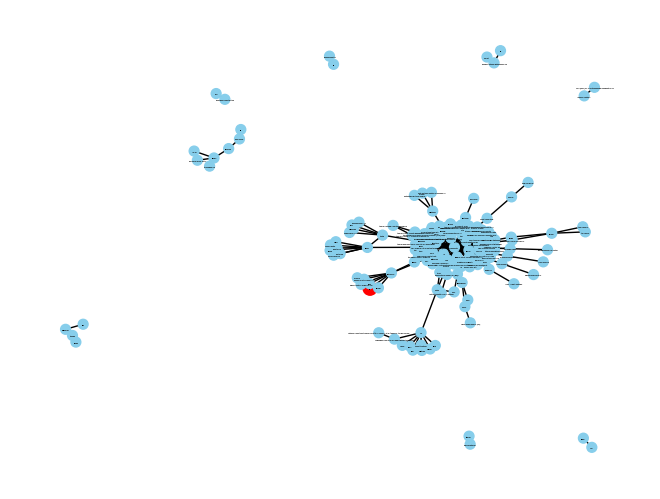

In [8]:
import networkx as nx
import matplotlib.pyplot as plt

# 그래프 생성
G = nx.Graph()

# 데이터 가공 및 그래프에 노드 및 엣지 추가
for company_list in connected_df.iloc[top30_connnection_idx]['assigned_companies_lst']:
    for i in range(len(company_list) - 1):
        G.add_edge(company_list[i], company_list[i + 1])
        if 'sk' in company_list[i] or 'sk' in company_list[i+1]:
            print(company_list)


special_node = 'sk'
node_colors = ['skyblue'] * len(G.nodes)

if special_node in G.nodes:
    print('there are sk')
    special_node_index = list(G.nodes).index(special_node)
    node_colors[special_node_index] = 'red'
        
    node_sizes = [50] * len(G.nodes)
    node_sizes[special_node_index] *= 2
    
# 그래프 시각화
pos = nx.spring_layout(G)  # 그래프 레이아웃 설정
nx.draw(G, pos, with_labels=True, font_weight='bold', node_color=node_colors, node_size=node_sizes, edge_color=[0,0,0], linewidths=1, font_size=1)


plt.show()


In [47]:
top50_connected_company = df_expanded['companies'].value_counts()[:50].index
'sk' in top50_connected_company

False

In [75]:
df_expanded=df_expanded.dropna(subset=['국제특허분류'])
df_expanded['ipc_code'] = df_expanded['국제특허분류'].apply(lambda x: x.split(','))
df_explode =df_expanded.explode(['ipc_code'])
df_explode['ipc_code']

0         G06F-001/20
0         G06F-003/06
1         F28D-020/00
2         F28D-020/00
2         F28F-009/22
             ...     
11390     B65B-063/08
11391     G21F-003/00
11391     F25B-019/00
11392     G06F-019/00
11393     G06F-019/00
Name: ipc_code, Length: 44607, dtype: object

In [76]:
df_explode['ipc_code_front'] = df_explode['ipc_code'].apply(lambda x : x.split('-')[0]).apply(lambda x : x.strip())
df_explode['ipc_code_front'] = df_explode['ipc_code'].apply(lambda x : x.split('-')[0]).apply(lambda x : x.strip())
len(df_explode['ipc_code'].value_counts())

6680

In [12]:
df_explode['ipc_code_front'] = df_explode['ipc_code'].apply(lambda x : x.split('-')[0]).apply(lambda x : x.strip())

main_ipc = df_explode['ipc_code_front'].value_counts()[:10]

In [13]:
df_explode['ipc_code_front'].value_counts()[:20]

ipc_code_front
F28D    8737
F25B    2534
F01K    1944
F24F    1941
F28F    1931
C09K    1851
H01M    1793
F24H    1498
F24D    1243
F25D    1046
F24J    1037
F02C     862
F24S     824
H02J     797
H01L     747
B60H     689
B01J     673
F01N     593
F03G     499
F22B     470
Name: count, dtype: int64

In [14]:
top10_connected_company = df_expanded['companies'].value_counts()[:10].index

In [15]:
# 내게 주어 진 것. 
# 잘 전처리된 회사들과 각각의 tes 특허 ipc 데이터
# 특허 비중 바탕 clustering
# 

In [16]:
df_explode.companies

0        western digital technologies
0        western digital technologies
1                        e2s power ag
2                          university
2                          university
                     ...             
11390                    tcp reliable
11391                          boeing
11391                          boeing
11392             general compression
11393             general compression
Name: companies, Length: 44607, dtype: object

In [17]:
df_explode['ipc_code_front'] = df_explode['ipc_code'].apply(lambda x : x.split('-')[0]).apply(lambda x : x.strip())

vector_table = df_explode.pivot_table(index='companies', columns='ipc_code_front', aggfunc='size', fill_value=0)
vector_table = vector_table.div(vector_table.sum(axis=1), axis=0)

from sklearn.metrics.pairwise import cosine_similarity

# 코사인 유사도 계산
similarity_matrix = cosine_similarity(vector_table)

# 결과 데이터프레임 생성
similarity_df = pd.DataFrame(similarity_matrix, index=vector_table.index, columns=vector_table.index)

# 결과 출력

similarity_df


companies,1414 degrees,2 canal view wharf farm,247solar,2555663 ontario,2cool finland oy,3279101 patent application trust,3dom,3m innovative properties,3scan,5th generation energy,...,zilinská univerzita v ziline,ziskind gennady,zlt lüftungs- und brandschutztechnik gmbh,zoox,zortea,zwinkels andrew,zymergen,züblin ag,ørsted wind power a/s,ørtoft holding aps
companies,,,,,,,,,,,,,,,,,,,,,
1414 degrees,1.000000,0.516398,0.176293,0.0,0.0,0.0,0.0,0.120386,0.000000,0.577350,...,0.547723,0.258199,0.000000,0.0,0.547723,0.198030,0.0,0.480079,0.0,0.408248
2 canal view wharf farm,0.516398,1.000000,0.151729,0.0,0.0,0.0,0.0,0.186501,0.000000,0.894427,...,0.848528,0.400000,0.316228,0.0,0.989949,0.306786,0.0,0.338062,0.0,0.632456
247solar,0.176293,0.151729,1.000000,0.0,0.0,0.0,0.0,0.035372,0.000000,0.169638,...,0.187755,0.075864,0.000000,0.0,0.160933,0.067883,0.0,0.235096,0.0,0.179928
2555663 ontario,0.000000,0.000000,0.000000,1.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
2cool finland oy,0.000000,0.000000,0.000000,0.0,1.0,0.0,0.0,0.147442,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwinkels andrew,0.198030,0.306786,0.067883,0.0,0.0,0.0,0.0,0.071520,0.000000,0.342997,...,0.325396,0.460179,0.000000,0.0,0.325396,1.000000,0.0,0.129641,0.0,0.242536
zymergen,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.948683,0.000000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,1.0,0.000000,0.0,0.000000
züblin ag,0.480079,0.338062,0.235096,0.0,0.0,0.0,0.0,0.078811,0.000000,0.377964,...,0.358569,0.169031,0.000000,0.0,0.358569,0.129641,0.0,1.000000,0.0,0.267261


In [56]:

main_ipc = df_explode['ipc_code_front'].value_counts()[1:6].index

main_vector_table =vector_table[main_ipc]

non_zero_rows = main_vector_table[(main_vector_table > 0).all(axis=1)]

# non_zero_rows의 인덱스를 리스트로 추출
non_zero_companies = non_zero_rows.index.tolist()

# 결과 출력
print("Companies with all values greater than 0:")
print(non_zero_companies)

Companies with all values greater than 0:
['People', 'abb', 'alliance for sustainable energy', 'cea', 'hitachi', 'kabushiki', 'mitsubishi', 'toho', 'toshiba', 'toyota', 'university']


In [57]:
for i in non_zero_companies:
    print(i,len(df_expanded[df_expanded['companies']==i]))

People 88
abb 42
alliance for sustainable energy 30
cea 122
hitachi 73
kabushiki 148
mitsubishi 219
toho 41
toshiba 85
toyota 349
university 908


In [58]:
top50_connected_company

Index(['university', 'toyota', 'siemens', 'denso', 'panasonic', 'mitsubishi',
       'valeo', 'kabushiki', 'cea', 'general electric', 'daikin', 'People',
       'toshiba', 'sumitomo', 'johnson controls', 'hitachi', 'sharp',
       'hutchinson', 'malta', 'yazaki', 'rolls-royce', 'keihin', 'nederlandse',
       'basf', 'lg', 'furukawa', 'ngk', 'ifp', 'carrier', 'abb',
       'german aerospace center', 'abengoa', 'toho', 'kaneka', 'phase',
       'intel', 'robert bosch gmbh', 'sunamp', 'nippon', 'calsonic kansei',
       'kyungdong navien', 'mahle', 'linde', 'hamilton', 'alstom',
       'ford global technologies', 'samsung', 'dow', 'fraunhofer-gesellschaft',
       'centre'],
      dtype='object', name='companies')

In [59]:
over10_company = df_expanded['companies'].value_counts().index[df_expanded['companies'].value_counts()>10]

In [60]:
sk_similarity>0

NameError: name 'sk_similarity' is not defined

In [61]:
sk_similarity = similarity_df.loc['sk'].loc[over10_company]

sk_similarity = sk_similarity[sk_similarity>0]

# Sort companies based on similarity in ascending order
low_corr_companies = sk_similarity.sort_values()

# Print or use the low correlation companies
print("Companies with low correlation to sk:")
print(low_corr_companies[:10])

Companies with low correlation to sk:
companies
gm                      0.024431
johnson controls        0.033354
electrolux              0.035158
coolbrook oy            0.035395
octopus energy group    0.042707
midea                   0.046694
qingdao                 0.047627
whirlpool               0.048785
rondo energy            0.053245
rolls-royce             0.057088
Name: sk, dtype: float64


In [293]:
for i in low_corr_companies[:10].index:
    print(i,len(df_expanded[df_expanded['companies']==i]))

gm 21
johnson controls 76
electrolux 19
coolbrook oy 16
octopus energy group 18
midea 23
qingdao 14
whirlpool 26
rondo energy 30
rolls-royce 62


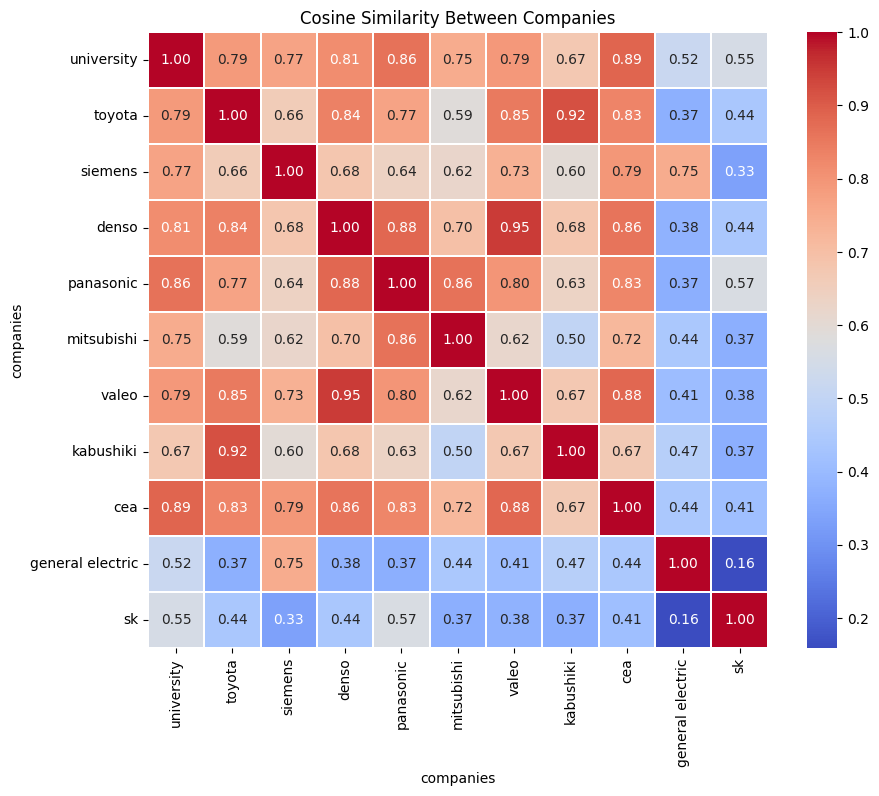

In [269]:
top10_sk_vector_table = vector_table.loc[list(top10_connected_company)+['sk']]
top10_sk_similarity_matrix = cosine_similarity(top10_sk_vector_table)

# 결과 데이터프레임 생성
top10_sk_similarity_df = pd.DataFrame(top10_sk_similarity_matrix, index=top10_sk_vector_table.index, columns=top10_sk_vector_table.index)

# 결과 출력

top10_sk_similarity_df

import seaborn as sns
import matplotlib.pyplot as plt

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(top10_sk_similarity_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.1)
plt.title('Cosine Similarity Between Companies')
plt.show()


In [359]:
vector_table.loc[over10_company].index[np.argmax(vector_table.loc[over10_company].loc[:,'F28D'])]

'saint-gobain'

In [361]:
vector_table.loc['saint-gobain'][vector_table.loc['saint-gobain']>0]

ipc_code_front
B23P    0.013889
C04B    0.222222
C09K    0.055556
F03G    0.027778
F24J    0.055556
F27B    0.041667
F27D    0.069444
F28D    0.486111
F28F    0.013889
G05D    0.013889
Name: saint-gobain, dtype: float64

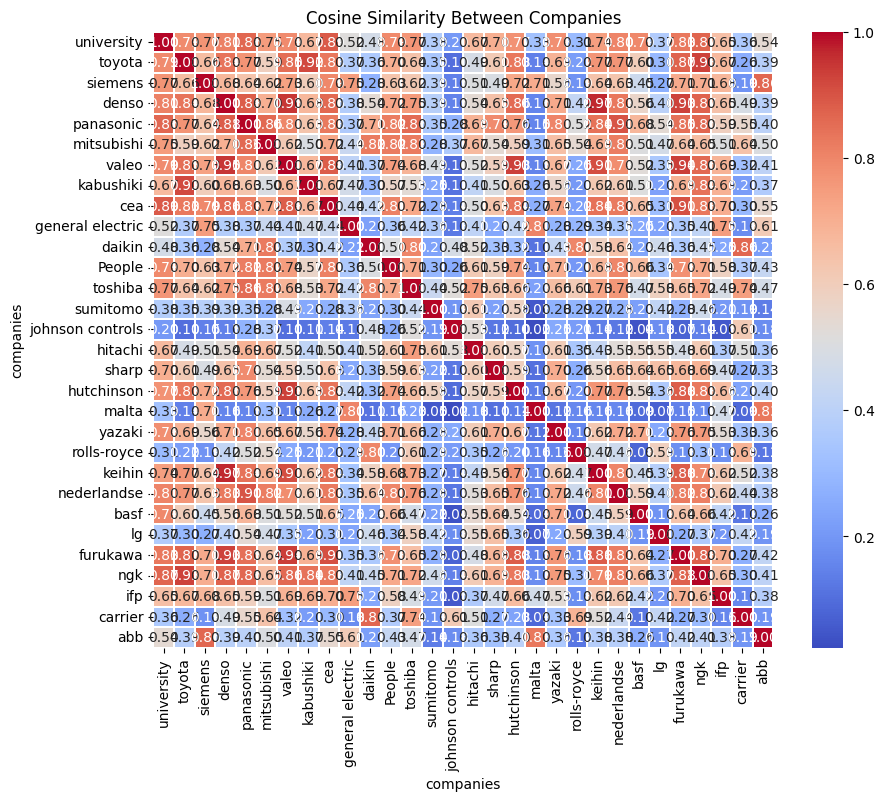

In [250]:
import seaborn as sns
import matplotlib.pyplot as plt

# 히트맵 시각화
plt.figure(figsize=(10, 8))
sns.heatmap(similarity_df.loc[top30_connected_company,top30_connected_company], annot=True, cmap='coolwarm', fmt=".2f", linewidths=.1)
plt.title('Cosine Similarity Between Companies')
plt.show()


In [240]:
top50_connected_company

Index(['university', 'toyota', 'siemens', 'denso', 'panasonic', 'mitsubishi',
       'valeo', 'kabushiki', 'cea', 'general electric', 'daikin', 'People',
       'toshiba', 'sumitomo', 'johnson controls', 'hitachi', 'sharp',
       'hutchinson', 'malta', 'yazaki', 'rolls-royce', 'keihin', 'nederlandse',
       'basf', 'lg', 'furukawa', 'ngk', 'ifp', 'carrier', 'abb',
       'german aerospace center', 'abengoa', 'toho', 'kaneka', 'phase',
       'intel', 'robert bosch gmbh', 'sunamp', 'nippon', 'calsonic kansei',
       'kyungdong navien', 'mahle', 'linde', 'hamilton', 'alstom',
       'ford global technologies', 'samsung', 'dow', 'fraunhofer-gesellschaft',
       'centre'],
      dtype='object', name='companies')

# 특허 분류 바탕으로 네트워크 그리기


In [ ]:
top20_similarity_df =similarity_df.loc[top20_company,top20_company]

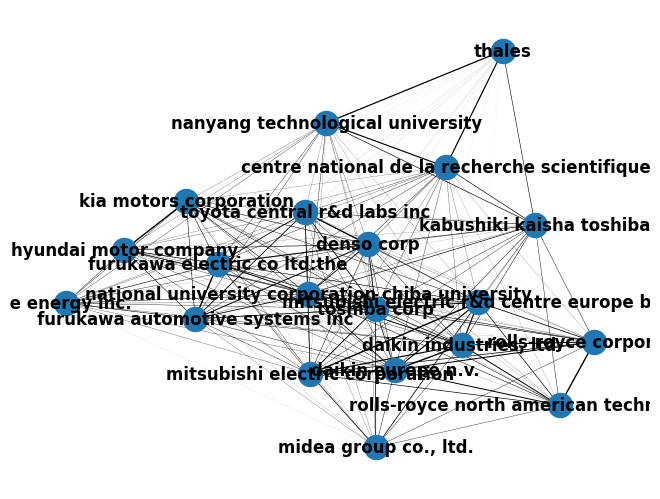

In [57]:


import matplotlib.pyplot as plt
import networkx as nx

# 네트워크 그래프 생성
G = nx.Graph()

# 노드 추가
G.add_nodes_from(top20_similarity_df.index)

# 엣지 및 두께 설정
for i in range(len(top20_similarity_df.index)):
    for j in range(i + 1, len(top20_similarity_df.index)):
        similarity = top20_similarity_df.iloc[i, j]
        if similarity > 0:  # 유사도가 0 이상인 경우에만 엣지 추가
            G.add_edge(top20_similarity_df.index[i], top20_similarity_df.index[j], weight=similarity)

# 두께 계산
widths = [data['weight'] for _, _, data in G.edges(data=True)]

# 네트워크 그리기
pos = nx.spring_layout(G)  # 레이아웃 설정
nx.draw(G, pos, with_labels=True, font_weight='bold', width=widths)

# 그래프 출력
plt.show()


In [297]:
vector_table

ipc_code_front,A01G,A01K,A01M,A01N,A23B,A23C,A23G,A23L,A24F,A41D,...,H04M,H04N,H04Q,H04R,H04W,H05B,H05G,H05H,H05K,H10N
companies,,,,,,,,,,,,,,,,,,,,,
1414 degrees,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2 canal view wharf farm,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
247solar,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2555663 ontario,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2cool finland oy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zwinkels andrew,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
zymergen,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
züblin ag,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


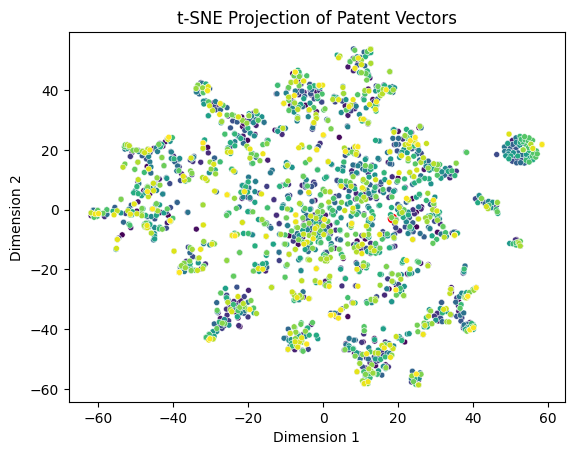

In [300]:
import seaborn as sns
from sklearn.manifold import TSNE

# t-SNE를 사용하여 벡터 값을 2차원에 투영
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(vector_table)

# 투영된 벡터 값을 데이터프레임으로 변환
df_2d = pd.DataFrame(vectors_2d, index=vector_table.index, columns=['Dimension 1', 'Dimension 2'])

plt.scatter(df_2d.loc['sk', 'Dimension 1'], df_2d.loc['sk', 'Dimension 2'], color='red', label='sk')


# 클러스터링을 위해 Seaborn을 사용하여 플로팅
sns.scatterplot(x='Dimension 1', y='Dimension 2', data=df_2d, hue=df_2d.index,size=100, palette='viridis', legend=False)
plt.title('t-SNE Projection of Patent Vectors')
plt.show()

In [38]:
df_2d

NameError: name 'df_2d' is not defined

c:\Users\Ksunwoo\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


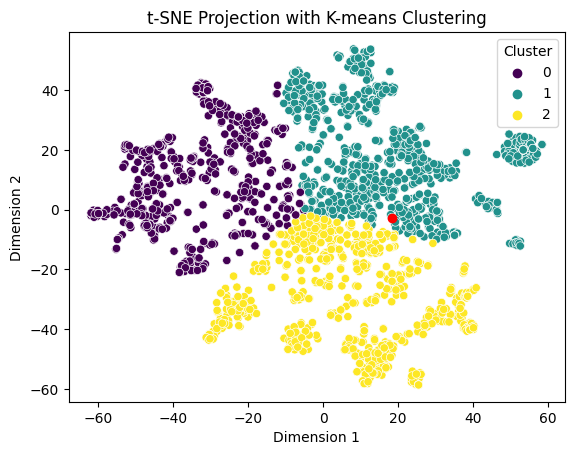

In [295]:

from sklearn.cluster import KMeans

# K-means 클러스터링을 적용
num_clusters = 3  # 클러스터의 개수를 조정할 수 있습니다.
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df_2d['Cluster'] = kmeans.fit_predict(vectors_2d)

# 클러스터링 결과 시각화
sns.scatterplot(x='Dimension 1', y='Dimension 2', data=df_2d, hue='Cluster', palette='viridis', legend='full')

plt.scatter(df_2d.loc['sk', 'Dimension 1'], df_2d.loc['sk', 'Dimension 2'], color='red', label='sk')

plt.title('t-SNE Projection with K-means Clustering')
plt.show()


In [68]:
df_2d[df_2d['Dimension 1']>130]

,Dimension 1,Dimension 2,Cluster
companies_lst,,,
aalborg csp a/s,133.286758,21.502811,2
"aldemir, alper",137.501846,16.493290,2
"bernroiter, siegfried",137.501846,16.493290,2
"binici, baris",136.239899,27.302792,2
caldic nederland b.v. (cal),152.108002,20.413052,2
chongqing university,137.501846,16.493290,2
clipsol,141.988922,30.927544,2
commissariat à l'energie atomique et aux energies alternatives,137.501846,16.493290,2
"enea, agencia nazionale per le nuove tecnologie, l' energia e lo sviluppo economico sostenibile",140.889450,26.250593,2


### 공개일 기반 가중치 부여 하여 simmilarity 수정 뽑고 비교 분석하면 될듯. 내일에게 맡긴다.

In [84]:
import datetime
def make_datetime(string):
    return datetime.datetime.strptime(string, '%Y.%m.%d')

In [87]:
df_explode_dropdate= df_explode.dropna(subset=['공개일'])

In [92]:
df_explode_dropdate['year'] = df_explode_dropdate['공개일'].apply(lambda x : make_datetime(x).year)

C:\Users\Ksunwoo\AppData\Local\Temp\ipykernel_8384\2311123470.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode_dropdate['year'] = df_explode_dropdate['공개일'].apply(lambda x : make_datetime(x).year)


In [111]:
df_explode_dropdate['year_coef'] = df_explode_dropdate['year'].apply(lambda x : weight_function(x))
df_explode_dropdate['year_coef']

C:\Users\Ksunwoo\AppData\Local\Temp\ipykernel_8384\2987641942.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode_dropdate['year_coef'] = df_explode_dropdate['year'].apply(lambda x : weight_function(x))


14       1.00000
14       1.00000
14       1.00000
14       1.00000
14       1.00000
          ...   
11161    0.28243
11161    0.28243
11161    0.28243
11192    0.28243
11192    0.28243
Name: year_coef, Length: 6135, dtype: float64

In [123]:
df_explode_dropdate['ipc_code_front'] = df_explode_dropdate['ipc_code'].apply(lambda x : x.split('-')[0])

vector_table = df_explode_dropdate.pivot_table(index='companies_lst', columns='ipc_code_front', aggfunc='size', fill_value=0)
sum(vector_table.loc['chongqing university'])

C:\Users\Ksunwoo\AppData\Local\Temp\ipykernel_8384\3076551403.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode_dropdate['ipc_code_front'] = df_explode_dropdate['ipc_code'].apply(lambda x : x.split('-')[0])


1

In [126]:
df_explode_dropdate['ipc_code_front'] = df_explode_dropdate['ipc_code'].apply(lambda x : x.split('-')[0])

weighted_vector_table = df_explode_dropdate.pivot_table(index='companies_lst', columns='ipc_code_front',values='year_coef', aggfunc='sum', fill_value=0)
weighted_vector_table = weighted_vector_table.div(weighted_vector_table.sum(axis=1), axis=0)

# 코사인 유사도 계산
weighted_similarity_matrix = cosine_similarity(weighted_vector_table)

# 결과 데이터프레임 생성
weighted_similarity_df = pd.DataFrame(weighted_similarity_matrix, index=weighted_vector_table.index, columns=weighted_vector_table.index)

# 결과 출력

weighted_similarity_df


C:\Users\Ksunwoo\AppData\Local\Temp\ipykernel_8384\1078942396.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode_dropdate['ipc_code_front'] = df_explode_dropdate['ipc_code'].apply(lambda x : x.split('-')[0])


companies_lst,oy,"aac acoustic technologies (shenzhen) co., ltd.","aac technologies (nanjing) co., ltd.",aalborg csp a/s,abengoa solar llc,academia sinica,act interior kk,"agency for science, technology and research","agenzia nazionale per le nuove tecnologie, l'energia e lo sviluppo economico sostenibile (enea)","ahola, jero",...,yokohama rubber co ltd:the,"york (wuxi) air conditioning and refrigeration co., ltd.",ze energy inc.,zehnder group international ag,zeon corporation,zhejiang university,"zhen ding technology co., ltd.","ziegler, klausdieter","ziegler, maximilian",zilinská univerzita v ziline
companies_lst,,,,,,,,,,,,,,,,,,,,,
oy,1.000000,0.0,0.0,0.333333,0.000000,0.0,0.0,0.219981,0.131607,0.235702,...,0.0,0.534522,0.423078,0.0,0.0,0.0,0.0,0.833333,0.833333,0.534311
"aac acoustic technologies (shenzhen) co., ltd.",0.000000,1.0,1.0,0.000000,0.000000,0.0,0.0,0.078134,0.000000,0.000000,...,0.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
"aac technologies (nanjing) co., ltd.",0.000000,1.0,1.0,0.000000,0.000000,0.0,0.0,0.078134,0.000000,0.000000,...,0.5,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
aalborg csp a/s,0.333333,0.0,0.0,1.000000,0.000000,0.0,0.0,0.438947,0.000000,0.235702,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.500000,0.500000,0.843649
abengoa solar llc,0.000000,0.0,0.0,0.000000,1.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.219186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zhejiang university,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,1.0,0.0,0.000000,0.000000,0.000000
"zhen ding technology co., ltd.",0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,0.000000,0.000000,0.000000
"ziegler, klausdieter",0.833333,0.0,0.0,0.500000,0.000000,0.0,0.0,0.274722,0.098706,0.235702,...,0.0,0.400892,0.317309,0.0,0.0,0.0,0.0,1.000000,1.000000,0.611646


In [107]:
df_explode_dropdate.pivot_table(index='companies_lst', columns='ipc_code_front', aggfunc = 'sum',fill_value=0)

F-Term                          \
ipc_code_front                                   A01N  A41D  A42B  A47F  A61B   
companies_lst                                                                   
 oy                                                 0     0     0     0     0   
aac acoustic technologies (shenzhen) co., ltd.      0     0     0     0     0   
aac technologies (nanjing) co., ltd.                0     0     0     0     0   
aalborg csp a/s                                     0     0     0     0     0   
abengoa solar llc                                   0     0     0     0     0   
...                                               ...   ...   ...   ...   ...   
zhejiang university                                 0     0     0     0     0   
zhen ding technology co., ltd.                      0     0     0     0     0   
ziegler, klausdieter                                0     0     0     0     0   
ziegler, maximilian                                 0     0     0     0     0   
zilinská univerzita v ziline                        0     0     0     0     0   

                                                                              \
ipc_code_front                                  B01D  B01J  B04C  B22F  B23K   
companies_lst                                                                  
 oy                                                0     0     0     0     0   
aac acoustic technologies (shenzhen) co., ltd.     0     0     0     0     0   
aac technologies (nanjing) co., ltd.               0     0     0     0     0   
aalborg csp a/s                                    0     0     0     0     0   
abengoa solar llc                                  0     0     0     0     0   
...                                              ...   ...   ...   ...   ...   
zhejiang university                                0     0     0     0     0   
zhen ding technology co., ltd.                     0     0     0     0     0   
ziegler, klausdieter                               0     0     0     0     0   
ziegler, maximilian                                0     0     0     0     0   
zilinská univerzita v ziline                       0     0     0     0     0   

                                                ... 현재소유자                      \
ipc_code_front                                  ...  H01L H01M H02J H02K H02M   
companies_lst                                   ...                             
 oy                                             ...     0    0    0    0    0   
aac acoustic technologies (shenzhen) co., ltd.  ...     0    0    0    0    0   
aac technologies (nanjing) co., ltd.            ...     0    0    0    0    0   
aalborg csp a/s                                 ...     0    0    0    0    0   
abengoa solar llc                               ...     0    0    0    0    0   
...                                             ...   ...  ...  ...  ...  ...   
zhejiang university                             ...     0    0    0    0    0   
zhen ding technology co., ltd.                  ...     0    0    0    0    0   
ziegler, klausdieter                            ...     0    0    0    0    0   
ziegler, maximilian                             ...     0    0    0    0    0   
zilinská univerzita v ziline                    ...     0    0    0    0    0   

                                                                         
ipc_code_front                                 H02N H02S H05B H05K H10N  
companies_lst                                                            
 oy                                               0    0    0    0    0  
aac acoustic technologies (shenzhen) co., ltd.    0    0    0    0    0  
aac technologies (nanjing) co., ltd.              0    0    0    0    0  
aalborg csp a/s                                   0    0    0    0    0  
abengoa solar llc                                 0    0    0    0    0  
...                                             ...  ...  ...  .

In [104]:
import numpy as np
df_explode_dropdate['ipc_code_front'] = df_explode_dropdate['ipc_code'].apply(lambda x: x.split('-')[0])

def weight_function(year, current_year =2023):
    weight = 0.9 ** (current_year - year)
    return weight

# 'year' 열을 기반으로 가중치를 부여하여 벡터 생성
weighted_vector_table = df_explode_dropdate.pivot_table(index='companies_lst', columns='ipc_code_front', aggfunc=lambda x: np.sum(x * weight_function(x)), fill_value=0)

# 벡터 정규화
weighted_vector_table = weighted_vector_table.div(weighted_vector_table.sum(axis=1), axis=0)

# 코사인 유사도 계산
weighted_similarity_matrix = cosine_similarity(weighted_vector_table)

# 결과 데이터프레임 생성
weighted_similarity_df = pd.DataFrame(weighted_similarity_matrix, index=weighted_vector_table.index, columns=weighted_vector_table.index)

# 결과 출력
weighted_similarity_df


C:\Users\Ksunwoo\AppData\Local\Temp\ipykernel_8384\1085135177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_explode_dropdate['ipc_code_front'] = df_explode_dropdate['ipc_code'].apply(lambda x: x.split('-')[0])


TypeError: unsupported operand type(s) for -: 'int' and 'str'

In [128]:
sk_range_vector_table = vector_table.loc[:,vector_table.loc['sk']>0]

sk_range_similarity_matrix = cosine_similarity(sk_range_vector_table)

sk_range_similarity_df = pd.DataFrame(sk_range_similarity_matrix, index=sk_range_vector_table.index, columns=sk_range_vector_table.index)

# 결과 출력

# sk_range_similarity_df

# import seaborn as sns
# import matplotlib.pyplot as plt

# # 히트맵 시각화
# plt.figure(figsize=(10, 8))
# sns.heatmap(sk_range_similarity_df, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.1)
# plt.title('Cosine Similarity Between Companies')
# plt.show()

In [129]:
sk_range_similarity = sk_range_similarity_df.loc['sk'].loc[over10_company]

sk_range_similarity = sk_range_similarity[sk_range_similarity>0]

# Sort companies based on similarity in ascending order
low_corr_companies = sk_range_similarity.sort_values()

# Print or use the low correlation companies
print("Companies with low correlation to sk in sk_range:")
print(low_corr_companies[:10])

Companies with low correlation to sk in sk_range:
companies
seagate                0.100504
intel                  0.265269
microsoft              0.303538
henkel                 0.321211
trane international    0.376705
nec                    0.390246
mahle                  0.402015
kyungdong navien       0.402015
calsonic kansei        0.402015
ge                     0.402015
Name: sk, dtype: float64


In [145]:
df_explode['ipc_code'].value_counts()

ipc_code
 F28D-020/00     2302
 F28D-020/02     1664
F28D-020/00      1398
F28D-020/02       898
C09K-005/06       559
                 ... 
 C10L-003/10        1
E04D-013/08         1
 E04D-013/076       1
 C10L-001/24        1
G21F-003/00         1
Name: count, Length: 6680, dtype: int64

In [150]:
df_explode['ipc_code_front'].value_counts()[:30]

ipc_code_front
F28D    8737
F25B    2534
F01K    1944
F24F    1941
F28F    1931
C09K    1851
H01M    1793
F24H    1498
F24D    1243
F25D    1046
F24J    1037
F02C     862
F24S     824
H02J     797
H01L     747
B60H     689
B01J     673
F01N     593
F03G     499
F22B     470
B65D     424
C04B     398
B01D     371
H05K     338
B32B     329
F17C     268
G06F     255
F01P     251
C01B     246
E04B     243
Name: count, dtype: int64

In [40]:

from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.manifold import TSNE

correlation_matrix = vector_table.corr()
mean_correlation_per_feature = correlation_matrix.mean(axis=0)
selected_features = mean_correlation_per_feature.abs().sort_values(ascending=False).index[:10]




special_vector_table = vector_table.loc[:,selected_features]


# t-SNE를 사용하여 벡터 값을 2차원에 투영
tsne = TSNE(n_components=2, random_state=42)
vectors_2d = tsne.fit_transform(special_vector_table)

# 투영된 벡터 값을 데이터프레임으로 변환
df_2d = pd.DataFrame(vectors_2d, index=special_vector_table.index, columns=['Dimension 1', 'Dimension 2'])




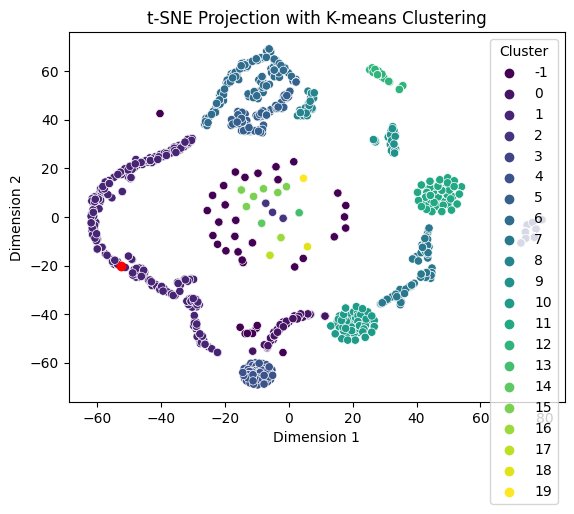

In [41]:
# # K-means 클러스터링을 적용
# num_clusters = 5 # 클러스터의 개수를 조정할 수 있습니다.
# kmeans = KMeans(n_clusters=num_clusters, random_state=42)
# df_2d['Cluster'] = kmeans.fit_predict(vectors_2d)
from sklearn.cluster import DBSCAN

# DBSCAN 클러스터링 적용
dbscan = DBSCAN(eps=5, min_samples=20)  # eps는 이웃을 결정하는 거리, min_samples는 클러스터를 형성하는데 필요한 최소 데이터 수
df_2d['Cluster'] = dbscan.fit_predict(vectors_2d)


# 클러스터링 결과 시각화
sns.scatterplot(x='Dimension 1', y='Dimension 2', data=df_2d, hue='Cluster', palette='viridis', legend='full')

plt.scatter(df_2d.loc['sk', 'Dimension 1'], df_2d.loc['sk', 'Dimension 2'], color='red', label='sk')

plt.title('t-SNE Projection with K-means Clustering')
plt.show()


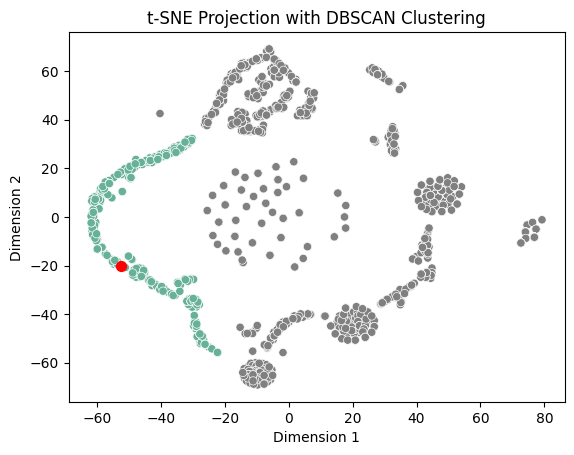

In [48]:
from sklearn.cluster import DBSCAN
import seaborn as sns
import matplotlib.pyplot as plt

# DBSCAN 클러스터링 적용
dbscan = DBSCAN(eps=5, min_samples=20)
df_2d['Cluster'] = dbscan.fit_predict(vectors_2d)

# 색상 설정
colors = {1: '#67B198'}  # 노이즈는 회색으로, 클러스터 0은 "#67B198"으로 색상 지정
df_2d['Color'] = df_2d['Cluster'].map(colors).fillna('gray')  # 'sk' 항목은 파란색으로 지정

# 클러스터링 결과 시각화
sns.scatterplot(x='Dimension 1', y='Dimension 2', data=df_2d, hue='Color', palette=dict(zip(unique_colors, unique_colors)), legend=False)

# 'sk' 항목 따로 표시
plt.scatter(df_2d.loc['sk', 'Dimension 1'], df_2d.loc['sk', 'Dimension 2'], color='red', label='sk',s=50)  # Use a shade of blue similar to the specified color

plt.title('t-SNE Projection with DBSCAN Clustering')
plt.show()


In [49]:
cluster_0_df = df_2d[df_2d['Cluster'] == 0]
cluster_1_df = df_2d[df_2d['Cluster'] == 1]
cluster_2_df = df_2d[df_2d['Cluster'] == 2]
cluster_3_df = df_2d[df_2d['Cluster'] == 3]
cluster_4_df = df_2d[df_2d['Cluster'] == 4]
cluster_5_df = df_2d[df_2d['Cluster'] == 5]
cluster_6_df = df_2d[df_2d['Cluster'] == 6]

# Print or use the cluster 1 dataframe
print("DataFrame for Cluster 1:")
print(cluster_1_df.index)

# over10_company = df_expanded['companies'].value_counts().index[df_expanded['companies'].value_counts()>20]

# less50_company = []
# for company in over10_company:
#     if ((df_expanded['companies'].value_counts()<30)[company]):
#         less50_company.append(company)
        
# l =set(cluster_1_df.index).intersection(set(less50_company))

# print(len(l))

DataFrame for Cluster 1:
Index(['247solar', '3m innovative properties', 'aac', 'abaco systems', 'abb',
       'abengoa', 'acme product development', 'acondicionamiento tarrasense',
       'adensis gmbh', 'agency',
       ...
       'x development', 'xi'an', 'xiaomi',
       'xuchang xuji jing rui science & technology co', 'yamauchi tamon',
       'yoshino gypsum co', 'ze energy', 'zhejiang cosin solar technology co',
       'zwinkels andrew', 'züblin ag'],
      dtype='object', name='companies', length=404)


In [50]:
top5_cluster_0 = df_expanded[df_expanded['companies'].isin(cluster_0_df.index)]['companies'].value_counts().head(5)
top5_cluster_1 = df_expanded[df_expanded['companies'].isin(cluster_1_df.index)]['companies'].value_counts().head(5)
top5_cluster_2 = df_expanded[df_expanded['companies'].isin(cluster_2_df.index)]['companies'].value_counts().head(5)
top5_cluster_3 = df_expanded[df_expanded['companies'].isin(cluster_3_df.index)]['companies'].value_counts().head(5)
top5_cluster_4 = df_expanded[df_expanded['companies'].isin(cluster_4_df.index)]['companies'].value_counts().head(5)

# 출력
print("Top 5 companies in Cluster 0:")
print(top5_cluster_0)

print("\nTop 5 companies in Cluster 1:")
print(top5_cluster_1)

print("\nTop 5 companies in Cluster 2:")
print(top5_cluster_2)

print("\nTop 5 companies in Cluster 3:")
print(top5_cluster_3)

print("\nTop 5 companies in Cluster 4:")
print(top5_cluster_4)


Top 5 companies in Cluster 0:
companies
siemens                    334
kabushiki                  148
ngk                         46
german aerospace center     42
toho                        41
Name: count, dtype: int64

Top 5 companies in Cluster 1:
companies
university          908
general electric    117
toshiba              85
sumitomo             81
johnson controls     76
Name: count, dtype: int64

Top 5 companies in Cluster 2:
companies
bayerische                12
all cell technologies      6
alcoa                      6
azbil                      4
accurec recycling gmbh     4
Name: count, dtype: int64

Top 5 companies in Cluster 3:
companies
eco-tech ceram               8
neothermal energy storage    4
ruag ammotec ag              3
hyperion                     3
energy systems management    3
Name: count, dtype: int64

Top 5 companies in Cluster 4:
companies
universiteit gent                      9
aichi                                  7
coldinnov                          

In [54]:



over10_less100_company = df_expanded['companies'].value_counts().index[
    (df_expanded['companies'].value_counts() >= 10)& (df_expanded['companies'].value_counts() <= 100)
]
common_indices = set(over10_less100_company) & set(cluster_1_df.index)


# 'vector_table'에서 공통된 인덱스를 선택
cluster1_vector = vector_table.loc[list(common_indices)]



In [55]:
cluster1_similarity_matrix = cosine_similarity(cluster1_vector)

cluster1_similarity_df = pd.DataFrame(cluster1_similarity_matrix, index=cluster1_vector.index, columns=cluster1_vector.index)
cluster1_similarity_df.head()

companies,sony,thermo,shell,x development,ford global technologies,electrolux,kawasaki,sunlight,coolbrook oy,e i du pont de nemours and,...,magaldi,midea,boeing,alstom,nippon,national,osaka,toshiba,dresser-rand,bae systems plc
companies,,,,,,,,,,,,,,,,,,,,,
sony,1.000000,0.028369,0.042497,0.028907,0.142880,0.012177,0.052663,0.324981,0.012259,0.072238,...,0.057954,0.016846,0.213925,0.016830,0.294326,0.068316,0.437235,0.247706,0.051446,0.177074
thermo,0.028369,1.000000,0.060183,0.158837,0.395572,0.843243,0.076424,0.106893,0.027777,0.137871,...,0.085954,0.292006,0.152741,0.047668,0.117467,0.105678,0.135288,0.521679,0.046227,0.249937
shell,0.042497,0.060183,1.000000,0.063368,0.206513,0.026693,0.101176,0.165461,0.218343,0.146173,...,0.124734,0.035451,0.195396,0.036893,0.146637,0.264954,0.217469,0.199125,0.069999,0.162490
x development,0.028907,0.158837,0.063368,1.000000,0.176996,0.159778,0.287990,0.116300,0.018279,0.089486,...,0.101814,0.110926,0.166139,0.627375,0.092762,0.087762,0.118340,0.323921,0.590418,0.186318
ford global technologies,0.142880,0.395572,0.206513,0.176996,1.000000,0.160504,0.301492,0.474537,0.059572,0.378312,...,0.284189,0.143914,0.518701,0.101207,0.385199,0.314104,0.390131,0.555295,0.155174,0.496141


In [56]:
# 'sk'와의 코사인 유사도를 기준으로 정렬
sorted_similarity_df = cluster1_similarity_df['sk'].sort_values(ascending=False)

print('sk와 가까운 기업 15개', list(sorted_similarity_df[1:16].index))
print('sk와 먼 기업 15개', list(sorted_similarity_df[-15:].index))

sk와 가까운 기업 15개 ['kaneka', 'fundación', 'jx', 'fujifilm', 'basf', 'entropy solutions', 'cold', 'inoac', 'showa', 'shenzhen enesoon science & technology co', 'e i du pont de nemours and', 'hitachi', 'dow', 'fraunhofer-gesellschaft', 'nippon']
sk와 먼 기업 15개 ['x development', 'nuovo', '247solar', 'sony', 'malta', 'alstom', 'emerson', 'rolls-royce', 'rondo energy', 'whirlpool', 'midea', 'coolbrook oy', 'electrolux', 'johnson controls', 'energy dome spa']


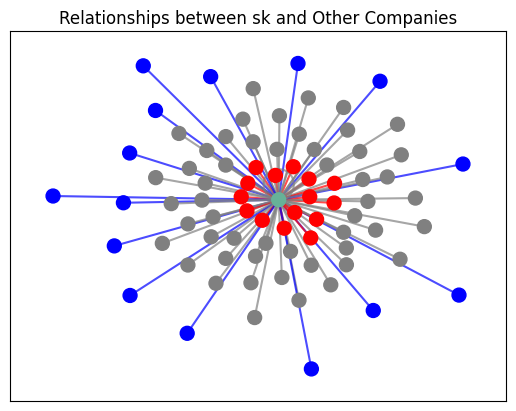

In [103]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'cluster1_vector' with vectors for each company in the cluster
# Compute the cosine similarity between 'sk' and other companies
sk_similarity = cosine_similarity(cluster1_vector.loc[['sk']], cluster1_vector).flatten()

# Create a DataFrame with the similarity values for 'sk'
sk_similarity_df = pd.DataFrame(sk_similarity, index=cluster1_vector.index, columns=['sk_similarity'])

# Create a network graph
G = nx.Graph()
sorted_similarity_df = cluster1_similarity_df['sk'].sort_values(ascending=False)

# Select 15 close and 15 distant companies
close_companies = list(sorted_similarity_df[1:16].index)
distant_companies = list(sorted_similarity_df[-15:].index)


# Add nodes and edges based on similarity values
for i in cluster1_vector.index:
    similarity = sk_similarity_df.loc[i, 'sk_similarity']
    # Map similarity to the color palette
    color = 'red' if i in close_companies else 'blue' if i in distant_companies else 'gray'
    G.add_node(i, color=color)
    G.add_edge('sk', i, weight=similarity, color=color)

# Draw the network graph with color-coded edges
pos = nx.spring_layout(G)  # You can choose a different layout algorithm if needed

# Extract node colors and edge colors
node_colors = [G.nodes[node]['color'] if node != 'sk' else '#67B198' for node in G.nodes]
edge_colors = [G['sk'][j]['color'] for j in G.neighbors('sk')]

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=node_colors, node_size=100, label='sk')

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color=edge_colors, width=1.5, alpha=0.7)

plt.title('Relationships between sk and Other Companies')
plt.show()

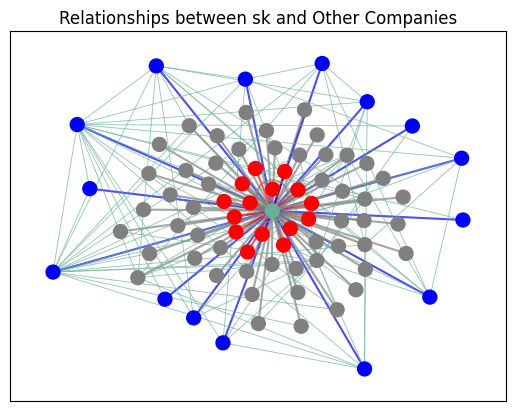

In [114]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'cluster1_vector' with vectors for each company in the cluster
# Compute the cosine similarity between 'sk' and other companies
sk_similarity = cosine_similarity(cluster1_vector.loc[['sk']], cluster1_vector).flatten()

# Create a DataFrame with the similarity values for 'sk'
sk_similarity_df = pd.DataFrame(sk_similarity, index=cluster1_vector.index, columns=['sk_similarity'])

# Create a network graph
G = nx.Graph()
sorted_similarity_df = cluster1_similarity_df['sk'].sort_values(ascending=False)

# Select 15 close and 15 distant companies
close_companies = list(sorted_similarity_df[1:16].index)
distant_companies = list(sorted_similarity_df[-15:].index)

# Add nodes and edges based on similarity values
for i in cluster1_vector.index:
    similarity = sk_similarity_df.loc[i, 'sk_similarity']
    # Map similarity to the color palette
    color = 'red' if i in close_companies else 'blue' if i in distant_companies else 'gray'
    G.add_node(i, color=color)
    G.add_edge('sk', i, weight=similarity, color=color)

# Draw the network graph with color-coded edges
pos = nx.spring_layout(G)  # You can choose a different layout algorithm if needed

# Extract node colors and edge colors
node_colors = [G.nodes[node]['color'] if node != 'sk' else '#67B198' for node in G.nodes]
edge_colors = [G['sk'][j]['color'] for j in G.neighbors('sk')]

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=node_colors, node_size=100, label='sk')

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color=edge_colors, width=1.5, alpha=0.7)

# Add edges between other nodes based on similarity values
for i in cluster1_vector.index:
    for j in cluster1_vector.index:
        if i != 'sk' and j != 'sk' and i != j:
            similarity = cosine_similarity(cluster1_vector.loc[[i]], cluster1_vector.loc[[j]]).flatten()[0]
            if similarity < 0.01 and similarity >- 0.01:  # Set your threshold for adding edges
                other_color = '#67B198'  # Set your color for additional edges
                nx.draw_networkx_edges(G, pos, edgelist=[(i, j)], edge_color=other_color, width=0.5, alpha=0.5)

plt.title('Relationships between sk and Other Companies')
plt.show()


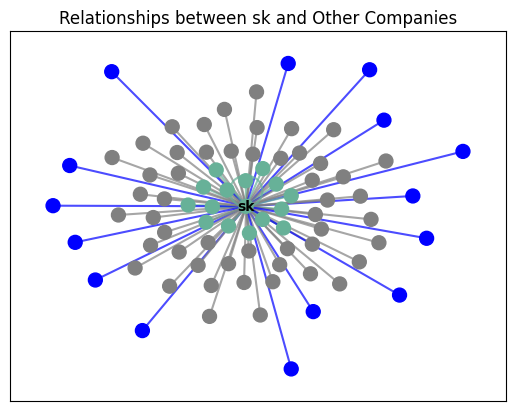

In [88]:
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have a DataFrame 'cluster1_vector' with vectors for each company in the cluster
# Compute the cosine similarity between 'sk' and other companies
sk_similarity = cosine_similarity(cluster1_vector.loc[['sk']], cluster1_vector).flatten()

# Create a DataFrame with the similarity values for 'sk'
sk_similarity_df = pd.DataFrame(sk_similarity, index=cluster1_vector.index, columns=['sk_similarity'])

# Create a network graph
G = nx.Graph()

# Add nodes and edges based on similarity values
for i in cluster1_vector.index:
    similarity = sk_similarity_df.loc[i, 'sk_similarity']
    # Map similarity to the color palette
    color = '#67B198' if i == 'sk' else '#67B198' if i in close_companies else 'blue' if i in distant_companies else 'gray'
    G.add_node(i, color=color)
    G.add_edge('sk', i, weight=similarity, color=color)

# Draw the network graph with color-coded edges
pos = nx.spring_layout(G)  # You can choose a different layout algorithm if needed

# Extract node colors and edge colors
node_colors = [G.nodes[node]['color'] for node in G.nodes]
edge_colors = [G['sk'][j]['color'] for j in G.neighbors('sk')]

# Draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=G.nodes, node_color=node_colors, node_size=100, label='sk')

# Draw edges
nx.draw_networkx_edges(G, pos, edgelist=G.edges, edge_color=edge_colors, width=1.5, alpha=0.7)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={'sk': 'sk'}, font_color='black', font_size=10, font_weight='bold')

plt.title('Relationships between sk and Other Companies')
plt.show()


In [68]:
df_explode[df_explode['companies']=='sk']

,일련번호,번호,명칭(원문),명칭(번역),요약(원문),요약(번역),출원인,출원인주소,출원인영문명,출원인국가,...,전용실시권자,통상실시권자,INPADOC패밀리국가,Simple패밀리국가,소유권이전여부,소유권최종양도일,특허전문 Link,companies,ipc_code,ipc_code_front
343,344,JP2023078528A2,HEAT STORAGE MATERIAL COMPOSITION AND HEAT STO...,NaN,PROBLEM TO BE SOLVED: To provide a heat storag...,NaN,sk kaken co ltd,NaN,NaN,JP,...,NaN,NaN,JP,JP,NaN,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,C09K-005/14,C09K
407,408,JP2023063261A2,HEAT STORAGE MATERIAL COMPOSITION,NaN,PROBLEM TO BE SOLVED: To provide a heat storag...,NaN,sk kaken co ltd,NaN,NaN,JP,...,NaN,NaN,JP,JP,NaN,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,C09K-005/06,C09K
651,652,JP2023019845A2,HEAT STORAGE COMPOSITION,NaN,PROBLEM TO BE SOLVED: To provide a heat storag...,NaN,sk kaken co ltd,NaN,NaN,JP,...,NaN,NaN,JP,JP,NaN,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,C09K-005/06,C09K
1499,1500,WO22071182A1,"HEAT STORAGE MATERIAL, HEAT STORAGE MATERIAL C...","축열재, 축열재 조성물 및 축열 성형체",Provided are: a heat storage material which ca...,"단, 축열성, 내 방산성 및 내 가수 분해성이 우수한 축열재; 축열재를 함유하고 축...","sk kaken co., ltd.|nof corporation","*-**, Nakahozumi *-chome, Ibaraki-shi, Osaka *...",NaN,JP|JP,...,NaN,NaN,"CN,JP,KR,WO","JP,KR,WO",NaN,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,C09K-005/06,C09K
1499,1500,WO22071182A1,"HEAT STORAGE MATERIAL, HEAT STORAGE MATERIAL C...","축열재, 축열재 조성물 및 축열 성형체",Provided are: a heat storage material which ca...,"단, 축열성, 내 방산성 및 내 가수 분해성이 우수한 축열재; 축열재를 함유하고 축...","sk kaken co., ltd.|nof corporation","*-**, Nakahozumi *-chome, Ibaraki-shi, Osaka *...",NaN,JP|JP,...,NaN,NaN,"CN,JP,KR,WO","JP,KR,WO",NaN,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,C08G-018/40,C08G
1499,1500,WO22071182A1,"HEAT STORAGE MATERIAL, HEAT STORAGE MATERIAL C...","축열재, 축열재 조성물 및 축열 성형체",Provided are: a heat storage material which ca...,"단, 축열성, 내 방산성 및 내 가수 분해성이 우수한 축열재; 축열재를 함유하고 축...","sk kaken co., ltd.|nof corporation","*-**, Nakahozumi *-chome, Ibaraki-shi, Osaka *...",NaN,JP|JP,...,NaN,NaN,"CN,JP,KR,WO","JP,KR,WO",NaN,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,F28D-020/02,F28D
1981,1982,US11455123,Data storage apparatus for thermal throttling ...,온도 조절을 위한 데이터 저장 장치 및 그것의 동작 방법,A data storage apparatus may include a storage...,데이터 저장 장치는 저장 장치의 측정 된 온도에 기초하여 제 1 성능 모드 및 제 ...,sk hynix inc.,"Gyeonggi-do , KR",NaN,KR,...,NaN,NaN,"CN,KR,US","CN,KR,US",N,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,G06F-003/06,G06F
1981,1982,US11455123,Data storage apparatus for thermal throttling ...,온도 조절을 위한 데이터 저장 장치 및 그것의 동작 방법,A data storage apparatus may include a storage...,데이터 저장 장치는 저장 장치의 측정 된 온도에 기초하여 제 1 성능 모드 및 제 ...,sk hynix inc.,"Gyeonggi-do , KR",NaN,KR,...,NaN,NaN,"CN,KR,US","CN,KR,US",N,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,G11C-011/56,G11C
1981,1982,US11455123,Data storage apparatus for thermal throttling ...,온도 조절을 위한 데이터 저장 장치 및 그것의 동작 방법,A data storage apparatus may include a storage...,데이터 저장 장치는 저장 장치의 측정 된 온도에 기초하여 제 1 성능 모드 및 제 ...,sk hynix inc.,"Gyeonggi-do , KR",NaN,KR,...,NaN,NaN,"CN,KR,US","CN,KR,US",N,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,G11C-016/04,G11C
2683,2684,JP2020196880A2,HEAT STORAGE MATERIAL COMPOSITION,NaN,PROBLEM TO BE SOLVED: To provide a heat storag...,NaN,sk kaken co ltd|mitsubishi chem infratec co ltd,NaN,NaN,JP|JP,...,NaN,NaN,JP,JP,NaN,NaN,"=HYPERLINK(""https://service.wisdomain.net/Full...",sk,C09K-005/06,C09K


In [1]:
df

NameError: name 'df' is not defined